<a href="https://colab.research.google.com/github/0Park/QA_LSTM/blob/main/QALSTM_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
QA_df=pd.read_csv('/content/drive/My Drive/QA_LSTM/QA_df.csv')

In [ ]:
dev_QA_df=pd.read_csv('/content/drive/My Drive/QA_LSTM/dev_QA_df.csv')

In [ ]:
import gensim
model=gensim.models.Word2Vec.load('/content/drive/My Drive/QA_LSTM/KorQuAD.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
question=QA_df['question']
answer=QA_df['answer']
text=pd.concat([question,answer],axis=0)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len=50

tokenizer=Tokenizer()
tokenizer.fit_on_texts(text)
q_sequences=tokenizer.texts_to_sequences(QA_df['question'])
a_sequences=tokenizer.texts_to_sequences(QA_df['answer'])

dev_q_sequences=tokenizer.texts_to_sequences(dev_QA_df['question'])
dev_a_sequences=tokenizer.texts_to_sequences(dev_QA_df['question'])

q_sequences=pad_sequences(q_sequences,maxlen=max_len)
a_sequences=pad_sequences(a_sequences,maxlen=max_len)

dev_q_sequences=pad_sequences(dev_q_sequences,maxlen=max_len)
dev_a_sequences=pad_sequences(dev_a_sequences,maxlen=max_len)
word_index=tokenizer.word_index
vocab_size=len(word_index)+1

In [ ]:
import numpy as np
Embedding_matrix=np.zeros((vocab_size,200))

for word, i in word_index.items():
    word=word.replace("'","")
    try:
        embedding_vector=model[word]
    except KeyError:
        continue
    Embedding_matrix[i]=embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [ ]:
an_sequences=np.array(a_sequences)
np.random.shuffle(an_sequences)

In [ ]:
dev_an_sequences=np.array(dev_a_sequences)
np.random.shuffle(dev_an_sequences)

In [ ]:
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional,MaxPool1D
from tensorflow.keras.layers import Lambda,Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

embedding_dim=200
max_len=50
hidden_size=50
margin=0.2

def get_cosine_similarity():
    dot=lambda a,b: K.batch_dot(a, b,axes=2)
    return lambda x: dot(x[0],x[1])/K.maximum(K.sqrt(dot(x[0],x[0])*dot(x[1],x[1])),K.epsilon())

question=Input(shape=(max_len,),dtype='float64',name='question_base')
answer=Input(shape=(max_len),dtype='float64',name='answer')
answer_good=Input(shape=(max_len),dtype='float64',name='answer_good_base')
answer_bad=Input(shape=(max_len,),dtype='float64',name='answer_bad_base')

qa_embedding=Embedding(vocab_size,embedding_dim,weights=[Embedding_matrix],input_length=max_len,trainable=True,mask_zero=True)
bi_lstm=Bidirectional(LSTM(units=hidden_size,dropout=0.2,return_sequences=True))

question_embedding=qa_embedding(question)
question_lstm=bi_lstm(question_embedding)
question_pooling=MaxPool1D(max_len)(question_lstm)

answer_embedding=qa_embedding(answer)
answer_lstm=bi_lstm(answer_embedding)
answer_pooling=MaxPool1D(max_len)(answer_lstm)

similarity=get_cosine_similarity()
question_answer_merged=Lambda(similarity,name='lambda_layer')([question_pooling,answer_pooling])
lstm_model=Model(name='q_bilstm',inputs=[question,answer],outputs=question_answer_merged)
good_similarity=lstm_model([question,answer_good])
bad_similarity=lstm_model([question,answer_bad])

# compute the loss
loss=Lambda(lambda x: K.maximum(0.0,margin-x[0]+x[1]))([good_similarity,bad_similarity])
#return training and prediction model

training_model=Model(inputs=[question,answer_good,answer_bad],outputs=loss,name='training_model')
training_model.compile(loss=lambda y_true,y_pred: y_pred,optimizer="rmsprop")
prediction_model=Model(inputs=[question,answer_good],outputs=good_similarity,name='prediction_model')
prediction_model.compile(loss=lambda y_true,y_pred: y_pred,optimizer='rmsprop')

In [ ]:
Y=np.zeros(shape=(q_sequences.shape[0],))
training_model.fit([q_sequences,a_sequences,an_sequences],Y,epochs=2,batch_size=64,validation_split=0.1,verbose=1)

Epoch 1/2
850/850 [==============================] - 474s 558ms/step - loss: 0.0148 - val_loss: 0.0112
Epoch 2/2
 54/850 [>.............................] - ETA: 7:05 - loss: 0.0066

KeyboardInterrupt: ignored

In [ ]:
training_model.save('/content/drive/My Drive/QA_LSTM/training_model3.h5')
prediction_model.save('/content/drive/My Drive/QA_LSTM/prediction_model2.h5')
training_model.save_weights('/content/drive/My Drive/QA_LSTM/training_weight2')

In [ ]:
training_model.summary()

Model: "training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
question_base (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
answer_good_base (InputLayer)   [(None, 50)]         0                                            
__________________________________________________________________________________________________
answer_bad_base (InputLayer)    [(None, 50)]         0                                            
__________________________________________________________________________________________________
q_bilstm (Functional)           (None, 1, 1)         12155800    question_base[0][0]              
                                                                 answer_good_base[0][

In [ ]:
prediction_model.summary()

Model: "prediction_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
question_base (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
answer_good_base (InputLayer)   [(None, 50)]         0                                            
__________________________________________________________________________________________________
q_bilstm (Functional)           (None, 1, 1)         12155800    question_base[0][0]              
                                                                 answer_good_base[0][0]           
Total params: 12,155,800
Trainable params: 12,155,800
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
prediction_model.load_weights('/content/drive/My Drive/QA_LSTM/training_weight2')

In [ ]:
x_array=np.array([dev_q_sequences[4000] for i in range(dev_q_sequences.shape[0])])
sim=prediction_model.predict([x_array,dev_a_sequences])

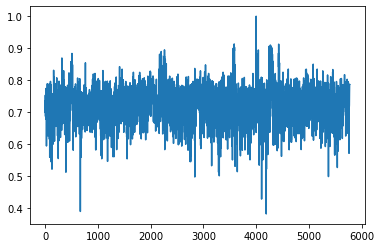

In [ ]:
import matplotlib.pyplot as plt
sim=sim.reshape(sim.shape[0],-1)
plt.plot(sim)

In [ ]:
acc=0
for j in range(dev_q_sequences.shape[0]):
  x_array=np.array([dev_q_sequences[j] for i in range(dev_q_sequences.shape[0])])
  sim=prediction_model.predict([x_array,dev_a_sequences])
  indice=np.argmax(sim)
  print("question, answer:",j,indice)
  acc+=1 if j == indice else 0
acc=acc/dev_q_sequences.shape[0]
print(acc)

question, answer: 0 0
question, answer: 1 1
question, answer: 2 2
question, answer: 3 3
question, answer: 4 4
question, answer: 5 5
question, answer: 6 6
question, answer: 7 7
question, answer: 8 8
question, answer: 9 9
question, answer: 10 10
question, answer: 11 11
question, answer: 12 12
question, answer: 13 13
question, answer: 14 14
question, answer: 15 15
question, answer: 16 16
question, answer: 17 17
question, answer: 18 18
question, answer: 19 19
question, answer: 20 20
question, answer: 21 21
question, answer: 22 22
question, answer: 23 23
question, answer: 24 24
question, answer: 25 25
question, answer: 26 26
question, answer: 27 27
question, answer: 28 28
question, answer: 29 29
question, answer: 30 30
question, answer: 31 31
question, answer: 32 32
question, answer: 33 33
question, answer: 34 34
question, answer: 35 35
question, answer: 36 36
question, answer: 37 37
question, answer: 38 38
question, answer: 39 39
question, answer: 40 40
question, answer: 41 41
question, an

KeyboardInterrupt: ignored